# OneClassSVM - Train on ASTRO data 3 FEATURES + predict on UNIDs

In [137]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import OneClassSVM
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import f1_score, confusion_matrix, classification_report, ConfusionMatrixDisplay, roc_curve, auc
from mpl_toolkits.mplot3d import Axes3D

In [138]:
# --- Cargar dataset ---
data_path = "../data/processed/XY_bal_log_Rel/astro/XY_bal_log_Rel_astro.txt"
df_astro = pd.read_csv(data_path, sep=r"\s+")

# Renombramos la columna target por claridad
df_astro = df_astro.rename(columns={"0,1=astro,DM": "class"})

# --- Comprobamos distribución del dataset ---
print(f"📁 Dataset cargado. Forma: {df_astro.shape}")
print(f"🧠 Nombres de las columnas: {list(df_astro.columns)}")

display(df_astro.head())


📁 Dataset cargado. Forma: (2831, 5)
🧠 Nombres de las columnas: ['E_peak', 'beta', 'sigma', 'beta_Rel', 'class']


,E_peak,beta,sigma,beta_Rel,class
0,-0.412502,-1.325139,1.356951,-0.122193,0.0
1,0.708140,-0.000174,0.623167,-1.601886,0.0
2,0.224740,-0.581202,1.010041,-0.311249,0.0
3,0.257319,-0.561933,0.615413,-0.038913,0.0
4,0.326110,-1.100179,1.624932,-0.528753,0.0


In [139]:
# --- Selección de características ---
features = ['E_peak', 'beta', 'beta_Rel']
target = 'class'

print(f"✅ Features seleccionadas: {features}")
print(f"🎯 Columna objetivo: {target}")

# --- Comprobamos valores nulos ---
print("\n🔍 Valores faltantes por columna:")
print(df_astro[features + [target]].isnull().sum())

print("\n📌 Muestra del dataset:")
display(df_astro[features + [target]].head())

✅ Features seleccionadas: ['E_peak', 'beta', 'beta_Rel']
🎯 Columna objetivo: class

🔍 Valores faltantes por columna:
E_peak      0
beta        0
beta_Rel    0
class       0
dtype: int64

📌 Muestra del dataset:


,E_peak,beta,beta_Rel,class
0,-0.412502,-1.325139,-0.122193,0.0
1,0.708140,-0.000174,-1.601886,0.0
2,0.224740,-0.581202,-0.311249,0.0
3,0.257319,-0.561933,-0.038913,0.0
4,0.326110,-1.100179,-0.528753,0.0


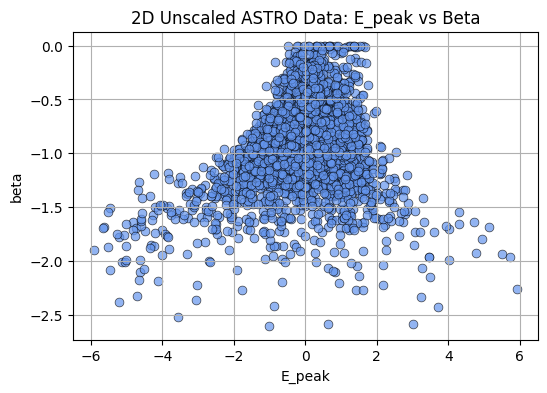

In [140]:
# Representación 2D
plt.figure(figsize=(6, 4))

sns.scatterplot(
    data=df_astro,
    x="E_peak",
    y="beta",
    color="cornflowerblue",  # "skyblue" "cornflowerblue"
    edgecolor='k',
    alpha=0.7,
    s=40
)

plt.title("2D Unscaled ASTRO Data: E_peak vs Beta")
plt.xlabel("E_peak")
plt.ylabel("beta")
plt.grid(True)
plt.show()

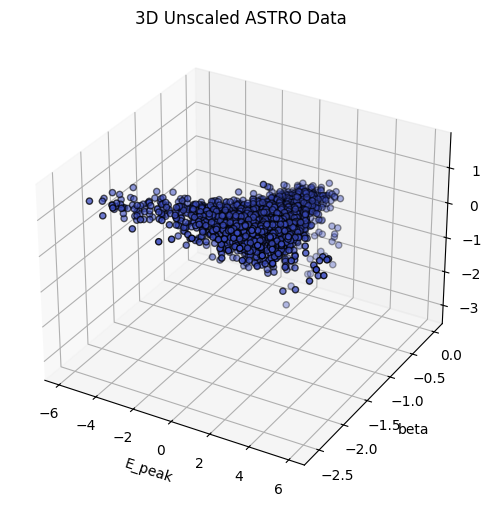

In [141]:
# Representación 3D
x = df_astro['E_peak']
y = df_astro['beta']
z = df_astro['beta_Rel']

labels = df_astro['class']

# Plot
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(x, y, z, c=labels, cmap='coolwarm', edgecolor='k')

ax.set_xlabel('E_peak')
ax.set_ylabel('beta')
ax.set_zlabel('beta_Rel')
plt.title('3D Unscaled ASTRO Data')
plt.show()


In [142]:
# Seleccionamos las features dinámicamente
X = df_astro[features].values
y = df_astro["class"].values

# Split: Train / Val / Test
# X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
# X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Hacemos una división estratificada para mantener la proporción de clases
# First stratified split: 60% train, 40% temp (val+test)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.4, stratify=y, random_state=42
)

# Second stratified split: 50% val, 50% test from temp
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42
)

# Escalado
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [143]:
print(X_train_scaled.shape)
print(X_val_scaled[0:5])

(1698, 3)
[[-0.24351357  0.39323477 -1.54240176]
 [-0.38997812  0.08721691 -0.99698046]
 [ 0.1003402   0.31355426  0.23533877]
 [ 0.12181659  0.98001672 -1.31941264]
 [-1.19895412 -0.63165042  0.58006866]]


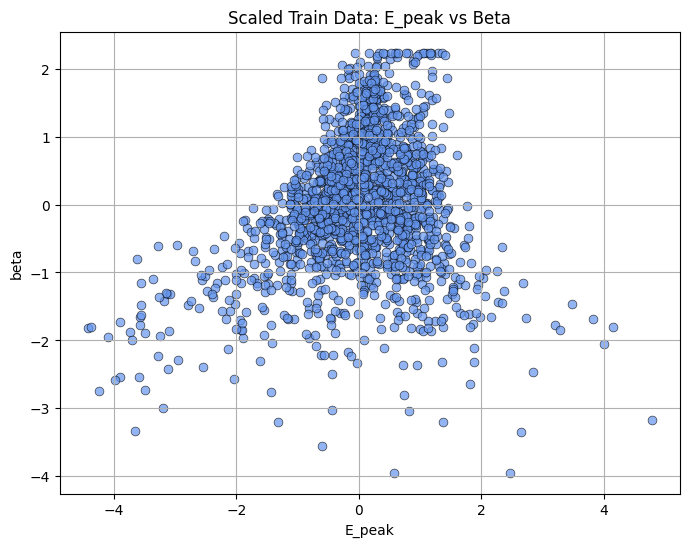

In [144]:
# Comprobamos que los datos están bien escalados
plt.figure(figsize=(8, 6))

sns.scatterplot(
    x=X_train_scaled[:, 0],
    y=X_train_scaled[:, 1],
    color="cornflowerblue",  # "skyblue" "cornflowerblue"
    edgecolor='k',
    alpha=0.7,
    s=40
)
plt.title("Scaled Train Data: E_peak vs Beta")
plt.xlabel("E_peak")
plt.ylabel("beta")
plt.grid(True)
plt.show()

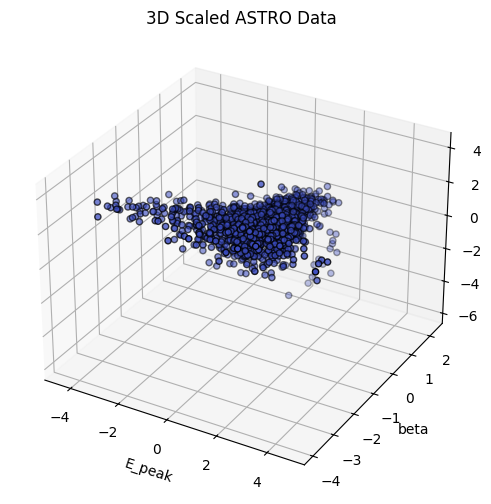

In [145]:
# Comprobamos los datos escalados
x = X_train_scaled[:, 0]
y = X_train_scaled[:, 1]
z = X_train_scaled[:, 2]

# Scatter plot 3D de X_train_scaled
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(x, y, z, c=y_train, cmap='coolwarm', edgecolor='k')
ax.set_xlabel('E_peak')
ax.set_ylabel('beta')
ax.set_zlabel('beta_Rel')
plt.title('3D Scaled ASTRO Data')
plt.show()


# Entrenar modelo + Validación

In [146]:
# OPTIMIZACION BASADA EN PUNTUACION F1 PARA DATOS ETIQUETADOS 

# --- Hiperparámetros a explorar ---
nu_values = [0.005, 0.01, 0.02, 0.05]
gamma_values = ['scale', 'auto'] + list(np.logspace(-3, 1, 5))

# --- Tracking de resultados ---
results = []
best_score = 0.0  # F1 score (cuanto más alto, mejor)
best_model = None
best_params = {}

# --- Grid Search ---
print("🔍 Iniciando búsqueda de hiperparámetros basada en F1-score...\n")
for nu in nu_values:
    for gamma in gamma_values:
        model = OneClassSVM(kernel='rbf', nu=nu, gamma=gamma)
        model.fit(X_train_scaled)

        # Predicciones
        preds = model.predict(X_val_scaled)              # 1 = inlier, -1 = outlier
        pred_labels = np.where(preds == 1, 0, 1)         # Mapear a 0 = normal, 1 = anomalía
        true_labels = y_val.astype(int)                  # Aseguramos tipo int

        # Evaluación
        f1 = f1_score(true_labels, pred_labels, pos_label=0)

        results.append({'nu': nu, 'gamma': gamma, 'f1_score': f1})

        if f1 > best_score:
            best_score = f1
            best_model = model
            best_params = {'nu': nu, 'gamma': gamma}

# --- Resultados Finales ---
print("✅ Mejor combinación de hiperparámetros:")
print(f"   - nu = {best_params['nu']}")
print(f"   - gamma = {best_params['gamma']}")
print(f"📈 Mejor F1-Score en validación: {best_score:.4f}")

# --- Convertimos resultados en DataFrame (opcional) ---
df_results = pd.DataFrame(results)
display(df_results.sort_values(by='f1_score', ascending=False))

🔍 Iniciando búsqueda de hiperparámetros basada en F1-score...

✅ Mejor combinación de hiperparámetros:
   - nu = 0.005
   - gamma = 0.01
📈 Mejor F1-Score en validación: 0.9956


,nu,gamma,f1_score
3,0.005,0.01,0.995563
2,0.005,0.001,0.994671
4,0.005,0.1,0.994671
9,0.010,0.001,0.993778
10,0.010,0.01,0.993778
11,0.010,0.1,0.991986
0,0.005,scale,0.988382
1,0.005,auto,0.988382
7,0.010,scale,0.988382
8,0.010,auto,0.988382


In [147]:
# Entrenamos el modelo con los mejores hiperparámetros
best_model = OneClassSVM(kernel='rbf', nu=best_params['nu'], gamma=best_params['gamma'])
best_model.fit(X_train_scaled)

OneClassSVM(gamma=np.float64(0.01), nu=0.005)

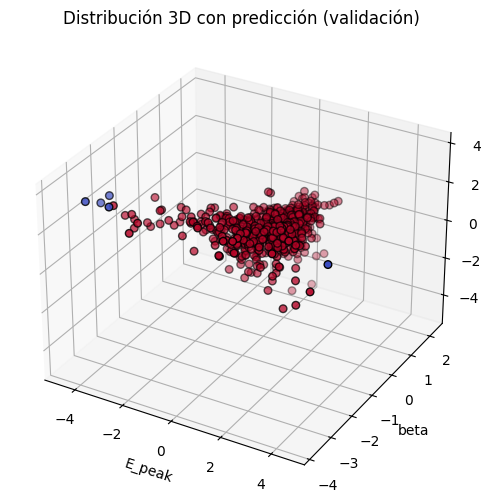

In [148]:
# Visualizamos predicciones en 3D sobre datos de validación
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

X_3d = X_val_scaled

# Predecimos de nuevo sobre validación para la visualización
preds = best_model.predict(X_3d)

ax.scatter(X_3d[:, 0], X_3d[:, 1], X_3d[:, 2], c=preds, cmap='coolwarm', edgecolor='k', s=30)

ax.set_xlabel(features[0])
ax.set_ylabel(features[1])
ax.set_zlabel(features[2])
plt.title("Distribución 3D con predicción (validación)")
plt.show()

# Doble comprobación con datos ASTRO reservados de prueba

In [149]:
# Evaluamos sobre los datos de prueba (X_test_scaled) con el mejor modelo ya entrenado
test_preds = best_model.predict(X_test_scaled)

n_test_outliers = np.sum(test_preds == -1)

print(f"Outliers en conjunto de datos reservado de prueba (test data): {n_test_outliers}")
test_labels = np.where(test_preds == 1, 0, 1)  # 1 = normal, -1 = outlier → mapeado
true_labels_test = y_test.astype(int)

print("\n📉 Matriz de confusión (Test Set):")
print(confusion_matrix(true_labels_test, test_labels))

print("\n📋 Reporte de clasificación:")
print(classification_report(y_test, test_labels, target_names=["Normal", "Anomalía"], zero_division=1))

Outliers en conjunto de datos reservado de prueba (test data): 4

📉 Matriz de confusión (Test Set):
[[563   4]
 [  0   0]]

📋 Reporte de clasificación:
              precision    recall  f1-score   support

      Normal       1.00      0.99      1.00       567
    Anomalía       0.00      1.00      0.00         0

    accuracy                           0.99       567
   macro avg       0.50      1.00      0.50       567
weighted avg       1.00      0.99      1.00       567



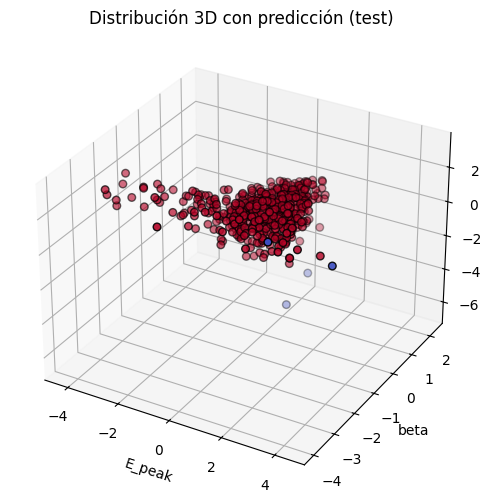

In [150]:
# Visualizamos predicciones en 3D sobre datos de prueba
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

X_3d = X_test_scaled
preds = best_model.predict(X_3d)
ax.scatter(X_3d[:, 0], X_3d[:, 1], X_3d[:, 2], c=preds, cmap='coolwarm', edgecolor='k', s=30)

ax.set_xlabel(features[0])
ax.set_ylabel(features[1])
ax.set_zlabel(features[2])
plt.title("Distribución 3D con predicción (test)")
plt.show()

# UNIDs

In [151]:
unids_path = "../data/raw/unids_3F_beta_err_names.txt"
df_unids = pd.read_csv(unids_path, sep='\s+')
df_unids.head()

,E_peak,beta,sigma_det,beta_Rel,number
0,2.51290,0.0897,7.3996,1.630992,0
1,1.47820,0.4163,5.4150,0.770838,1
2,1.59640,0.6783,10.7909,0.371222,2
3,0.93095,0.2771,7.6056,0.628654,3
4,0.44480,0.3207,4.2748,0.567509,4


In [152]:
# convertimos a logaritmo
cols_to_log = ["E_peak", "beta", "sigma_det", "beta_Rel"]
df_unids_log = df_unids.copy()
df_unids_log[cols_to_log] = df_unids_log[cols_to_log].apply(lambda x: np.log10(x.clip(lower=1e-10)))

In [153]:
# Extraer y escalar
X_unids_log = df_unids_log[["E_peak", "beta", "beta_Rel"]].values
X_unids_scaled = scaler.transform(X_unids_log)

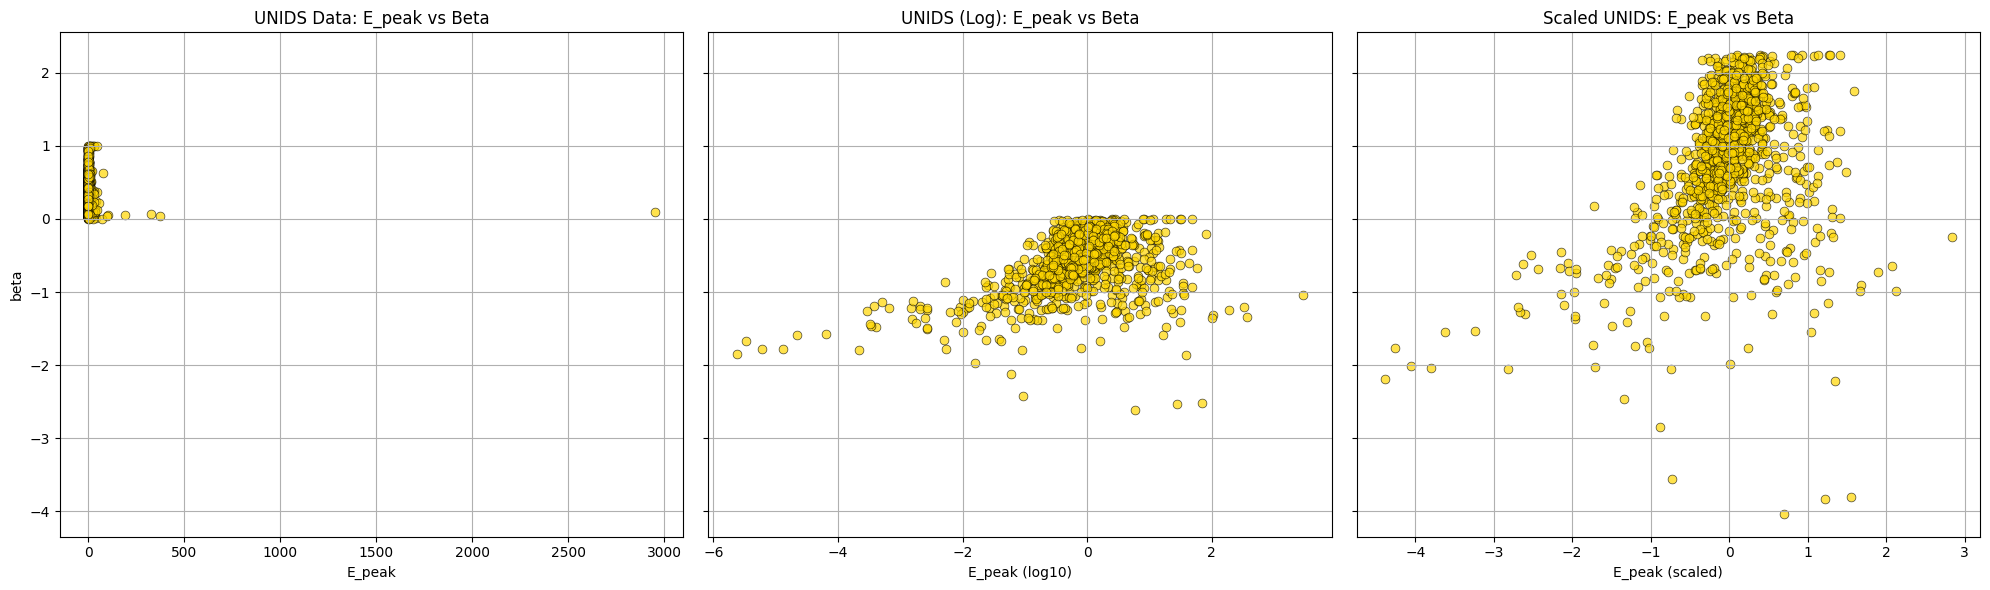

In [154]:
# --- Create subplots ---
fig, axes = plt.subplots(1, 3, figsize=(20, 6), sharey=True)

# --- Plot 1: Raw UNIDS data ---
sns.scatterplot(
    data=df_unids,
    x="E_peak",
    y="beta",
    color="gold",
    edgecolor='k',
    alpha=0.7,
    s=40,
    ax=axes[0]
)
axes[0].set_title("UNIDS Data: E_peak vs Beta")
axes[0].set_xlabel("E_peak")
axes[0].set_ylabel("beta")
axes[0].grid(True)

# --- Plot 2: Log-transformed UNIDS ---
sns.scatterplot(
    data=df_unids_log,
    x="E_peak",
    y="beta",
    color="gold",
    edgecolor='k',
    alpha=0.7,
    s=40,
    ax=axes[1]
)
axes[1].set_title("UNIDS (Log): E_peak vs Beta")
axes[1].set_xlabel("E_peak (log10)")
axes[1].set_ylabel("")  # hide repeated ylabel
axes[1].grid(True)

# --- Plot 3: Scaled UNIDS ---
sns.scatterplot(
    x=X_unids_scaled[:, 0],
    y=X_unids_scaled[:, 1],
    color="gold",
    edgecolor='k',
    alpha=0.7,
    s=40,
    ax=axes[2]
)
axes[2].set_title("Scaled UNIDS: E_peak vs Beta")
axes[2].set_xlabel("E_peak (scaled)")
axes[2].set_ylabel("")  # hide repeated ylabel
axes[2].grid(True)

plt.tight_layout()
plt.show()


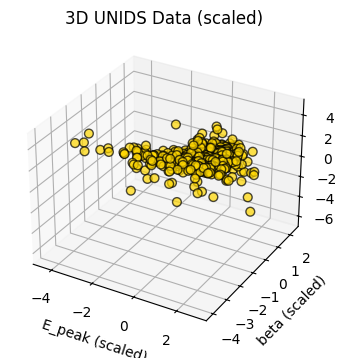

In [155]:
# Visualización de 3D de UNIDS
fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(X_unids_scaled[:, 0], X_unids_scaled[:, 1], X_unids_scaled[:, 2], color="gold", edgecolor='k', alpha=0.7, s=40)
ax.set_xlabel('E_peak (scaled)')
ax.set_ylabel('beta (scaled)')
ax.set_zlabel('beta_Rel (scaled)')
plt.title('3D UNIDS Data (scaled)')
plt.show()

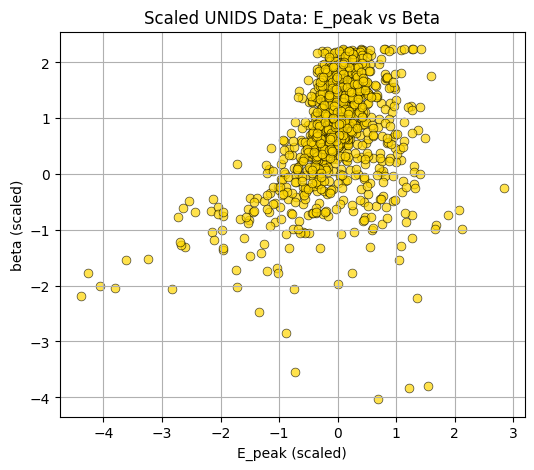

In [156]:
# Scatter de unids después de escalar
plt.figure(figsize=(6, 5))
sns.scatterplot(
    x=X_unids_scaled[:, 0],
    y=X_unids_scaled[:, 1],
    color="gold",  # "skyblue" "cornflowerblue"
    edgecolor='k',
    alpha=0.7,
    s=40
)
plt.title("Scaled UNIDS Data: E_peak vs Beta")
plt.xlabel("E_peak (scaled)")
plt.ylabel("beta (scaled)")
plt.grid(True)
plt.show()

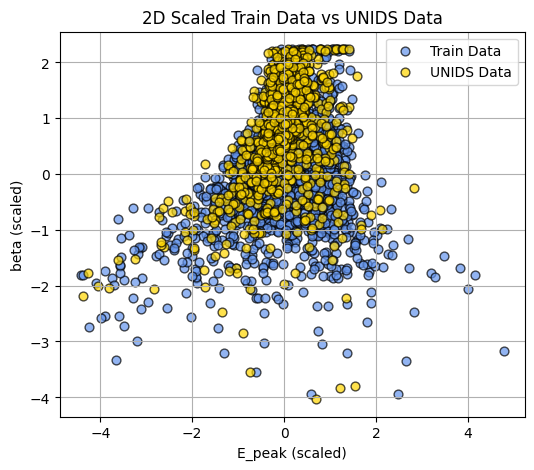

In [157]:
# Scatter de X_unids_scaled vs X_train_scaled 2D
plt.figure(figsize=(6, 5))
plt.scatter(X_train_scaled[:, 0], X_train_scaled[:, 1], color="cornflowerblue", edgecolor='k', alpha=0.7, s=40, label="Train Data")
plt.scatter(X_unids_scaled[:, 0], X_unids_scaled[:, 1], color="gold", edgecolor='k', alpha=0.7, s=40, label="UNIDS Data")
plt.title("2D Scaled Train Data vs UNIDS Data")
plt.xlabel("E_peak (scaled)")
plt.ylabel("beta (scaled)")
plt.legend()
plt.grid(True)
plt.show()

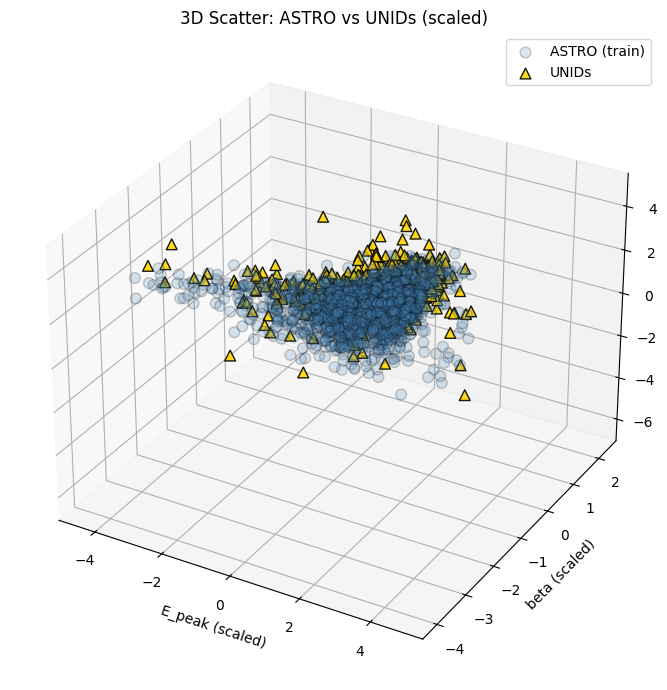

In [158]:
# Scatter de UNIDs vs ASTRO 3D
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Scatter ASTRO (training data)
ax.scatter(
    X_train_scaled[:, 0], X_train_scaled[:, 1], X_train_scaled[:, 2],
    color="steelblue", edgecolor='k', alpha=0.2, s=60, label='ASTRO (train)',
)

# Scatter UNIDs (to predict)
ax.scatter(
    X_unids_scaled[:, 0], X_unids_scaled[:, 1], X_unids_scaled[:, 2],
    color="gold", edgecolor='k', alpha=0.9, s=60, label='UNIDs',
    marker='^'
)

ax.set_xlabel('E_peak (scaled)')
ax.set_ylabel('beta (scaled)')
ax.set_zlabel('beta_Rel (scaled)')
ax.set_title('3D Scatter: ASTRO vs UNIDs (scaled)')

ax.legend()
plt.tight_layout()
plt.show()


In [159]:
# Predicciones sobre UNIDS
unids_preds = best_model.predict(X_unids_scaled)

n_unids_outliers = np.sum(unids_preds == -1)
n_unids_normals = np.sum(unids_preds == 1)

print(f"🚀 Predicted ASTRO-like: {n_unids_normals}")
print(f"❗ Predicted not ASTRO-like (anomalies): {n_unids_outliers}")
unids_labels = np.where(unids_preds == 1, 0, 1)  # 1 = normal, -1 = outlier → mapeado

🚀 Predicted ASTRO-like: 1120
❗ Predicted not ASTRO-like (anomalies): 5


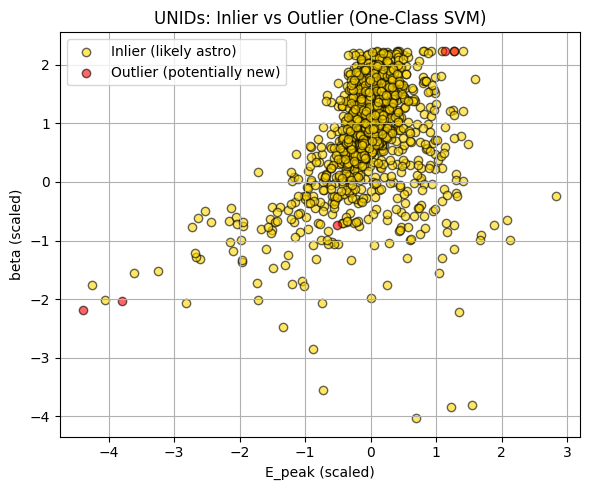

In [160]:
inliers = X_unids_scaled[unids_preds == 1]
outliers = X_unids_scaled[unids_preds == -1]

plt.figure(figsize=(6, 5))
plt.scatter(inliers[:, 0], inliers[:, 1], c='gold', edgecolors='k', label='Inlier (likely astro)', alpha=0.6)
plt.scatter(outliers[:, 0], outliers[:, 1], c='red', edgecolors='k', label='Outlier (potentially new)', alpha=0.6)

plt.xlabel("E_peak (scaled)")
plt.ylabel("beta (scaled)")
plt.title("UNIDs: Inlier vs Outlier (One-Class SVM)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

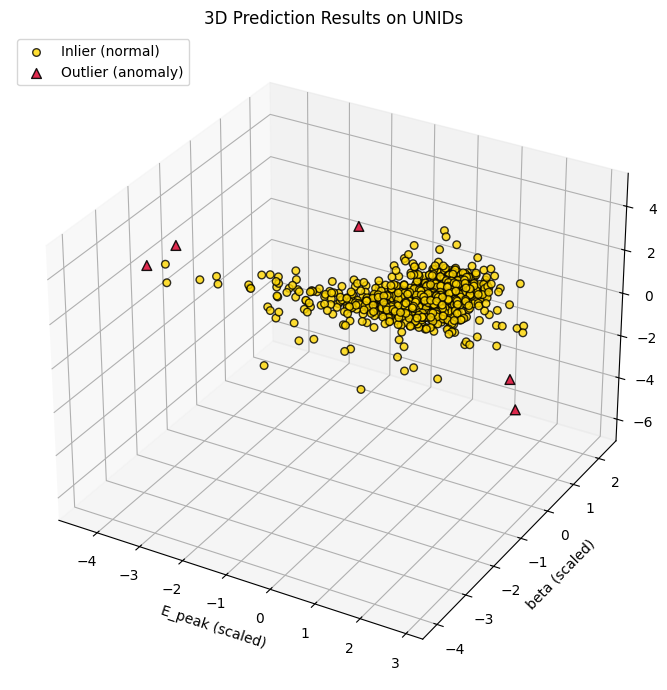

In [161]:
# Visualizamos predicciones en 3D sobre UNIDS

# Get predictions from best model on UNIDs
preds = best_model.predict(X_unids_scaled)  # 1 = inlier, -1 = outlier

# Separate indices
inlier_idx = preds == 1
outlier_idx = preds == -1

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Inliers (normal)
ax.scatter(
    X_unids_scaled[inlier_idx, 0], X_unids_scaled[inlier_idx, 1], X_unids_scaled[inlier_idx, 2],
    c='gold', edgecolor='k', s=30, label='Inlier (normal)', alpha=0.8
)

# Outliers (potential dark matter)
ax.scatter(
    X_unids_scaled[outlier_idx, 0], X_unids_scaled[outlier_idx, 1], X_unids_scaled[outlier_idx, 2],
    c='crimson', marker='^', edgecolor='k', s=50, label='Outlier (anomaly)', alpha=0.9
)

ax.set_xlabel('E_peak (scaled)')
ax.set_ylabel('beta (scaled)')
ax.set_zlabel('beta_Rel (scaled)')
ax.set_title("3D Prediction Results on UNIDs")

ax.legend(loc='upper left')
plt.tight_layout()
plt.show()


# Anomaly Scoring - UNIDs

In [162]:
decision_scores = best_model.decision_function(X_unids_scaled)  # Higher = more normal, lower = more anomalous

unids_preds = best_model.predict(X_unids_scaled)  # 1 = inlier, -1 = outlier

df_unids_log["svm_score"] = decision_scores
df_unids_log["prediction"] = unids_preds

anom_scores = -decision_scores  # Invert: higher = more anomalous
anom_percent = MinMaxScaler(feature_range=(0, 100)).fit_transform(anom_scores.reshape(-1, 1)).flatten()

df_unids_log["Anomaly_Score"] = anom_scores
df_unids_log["Anomaly_Rank(%)"] = anom_percent

top_anomalies = df_unids_log[df_unids_log["prediction"] == -1].sort_values(by="Anomaly_Rank(%)", ascending=False).head(10)
most_anomalous_idx = top_anomalies.index

top_anomalies.to_csv("../data/processed/unids_most_anomalous.txt", sep="\t", index=False)

print("Top Most Anomalous UNID Sources (3F One-Class SVM):")
display(top_anomalies[['number', 'Anomaly_Score', 'Anomaly_Rank(%)']])

Top Most Anomalous UNID Sources (3F One-Class SVM):


,number,Anomaly_Score,Anomaly_Rank(%)
307,307,0.397797,100.000000
562,562,0.123672,80.109072
1109,1109,0.086583,77.417846
285,285,0.058611,75.388185
166,166,0.001944,71.276336


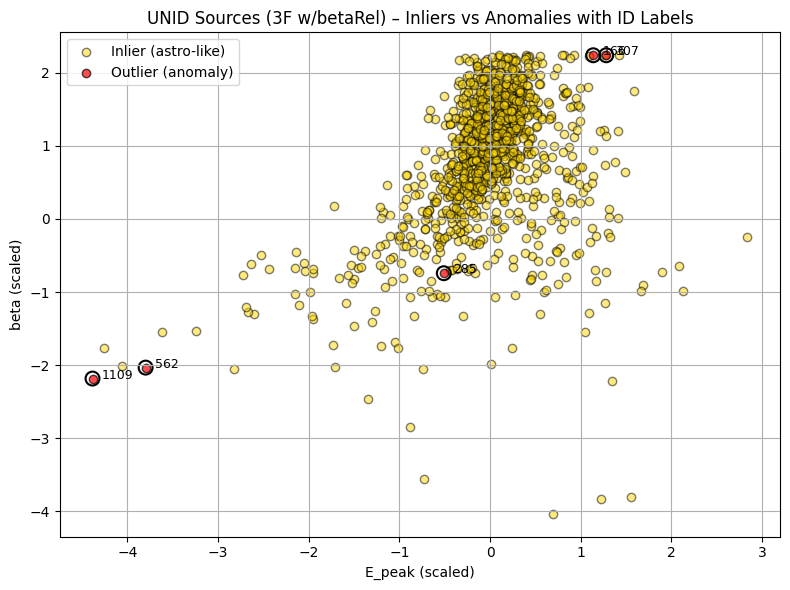

In [ ]:
# Get scaled values (for consistent comparison)
X_unids = X_unids_scaled  # already scaled

# Separate inliers and outliers
inliers = X_unids[unids_preds == 1]
outliers = X_unids[unids_preds == -1]

# Get anomaly info
top_anomalies = df_unids_log[df_unids_log["prediction"] == -1].sort_values(by="Anomaly_Rank(%)", ascending=False).head(10)
most_anomalous_idx = top_anomalies.index

# Extract for plotting
E_peak = X_unids[:, 0]
beta = X_unids[:, 1]

# Plot
plt.figure(figsize=(8, 6))

# All points
plt.scatter(inliers[:, 0], inliers[:, 1], c='gold', edgecolors='k', label='Inlier (astro-like)', alpha=0.5)
plt.scatter(outliers[:, 0], outliers[:, 1], c='red', edgecolors='k', label='Outlier (anomaly)', alpha=0.7)

# Highlight & label top anomalies
for idx in most_anomalous_idx:
    x = X_unids[idx, 0]
    y = X_unids[idx, 1]
    source_id = df_unids_log.loc[idx, 'number']
    
    plt.scatter(x, y, facecolors='none', edgecolors='black', linewidths=1.5, s=100)
    plt.text(x + 0.1, y, str(int(source_id)), color='black', fontsize=9)

# Labels and layout
plt.xlabel("E_peak (scaled)")
plt.ylabel("beta (scaled)")
plt.title("UNID Sources (3F w/betaRel) – Inliers vs Anomalies with ID Labels")
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.savefig("../outputs/figures/3F_betaRel_UNIDs_OneClassSVM_2D.png", dpi=300, bbox_inches='tight')

plt.show()


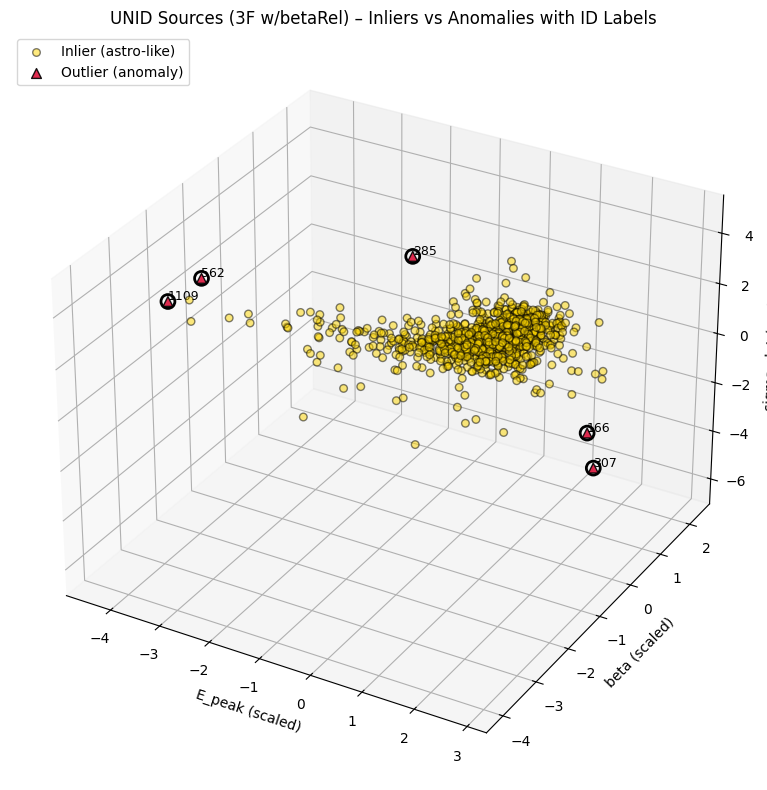

In [ ]:
# Get top anomalies (already computed and sorted by anomaly rank)
top_anomalies = df_unids_log[df_unids_log["prediction"] == -1].sort_values(by="Anomaly_Rank(%)", ascending=False).head(10)
most_anomalous_idx = top_anomalies.index

# Prepare figure
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Inliers (gold)
ax.scatter(
    X_unids_scaled[inlier_idx, 0],
    X_unids_scaled[inlier_idx, 1],
    X_unids_scaled[inlier_idx, 2],
    c='gold', edgecolor='k', s=30, label='Inlier (astro-like)', alpha=0.5
)

# Outliers (crimson)
ax.scatter(
    X_unids_scaled[outlier_idx, 0],
    X_unids_scaled[outlier_idx, 1],
    X_unids_scaled[outlier_idx, 2],
    c='crimson', marker='^', edgecolor='k', s=50, label='Outlier (anomaly)', alpha=0.9
)

# Annotate top anomalies
for idx in most_anomalous_idx:
    x = X_unids_scaled[idx, 0]
    y = X_unids_scaled[idx, 1]
    z = X_unids_scaled[idx, 2]
    source_id = df_unids_log.loc[idx, 'number']

    ax.scatter(x, y, z, facecolors='none', edgecolors='black', linewidths=2, s=100)
    ax.text(x, y, z + 0.05, str(int(source_id)), color='black', fontsize=9)

# Axes labels
ax.set_xlabel('E_peak (scaled)')
ax.set_ylabel('beta (scaled)')
ax.set_zlabel('sigma_det (scaled)')
ax.set_title("UNID Sources (3F w/betaRel) – Inliers vs Anomalies with ID Labels")

ax.legend(loc='upper left')
plt.tight_layout()

plt.savefig("../outputs/figures/3F_betaRel_UNIDs_OneClassSVM_3D.png", dpi=300, bbox_inches='tight')

plt.show()


# Compare UNIDs most anomalous vs ANN most DM-like

In [165]:
ann_unids_path = "./4F_ANN/unids_DM_std_proba_check_repeated_kfold_rskf_4F_21.txt"

raw_ann_unids_data = np.genfromtxt(ann_unids_path, dtype='str')
ann_unids_data = np.asarray(raw_ann_unids_data[1:], dtype=float)  # Salta cabecera
n_samples = ann_unids_data.shape[1] - 1

# Build DataFrame with probabilities per fold
columns = ['number'] + [f'prob_{i}' for i in range(n_samples)]
df_unids_ann = pd.DataFrame(ann_unids_data, columns=columns)

# Average probabilities per UNID (group by number)
df_mean_unids_ann = df_unids_ann.groupby('number').mean().reset_index()
df_mean_unids_ann['prob_ann'] = df_mean_unids_ann[[f'prob_{i}' for i in range(n_samples)]].mean(axis=1)

df_mean_unids_ann.head()

,number,prob_0,prob_ann
0,0.0,1.860129e-10,1.860129e-10
1,1.0,3.032059e-01,3.032059e-01
2,2.0,5.515580e-01,5.515580e-01
3,3.0,1.494101e-01,1.494101e-01
4,4.0,2.391825e-01,2.391825e-01


In [166]:
# Get the 10 sources with the highest mean ANN DM probability
top_ann_unids = df_mean_unids_ann.sort_values('prob_ann', ascending=False).head(50)

# Display results
print("🔝 Top 10 UNIDs with highest ANN-based DM probability:")
display(top_ann_unids[['number', 'prob_ann']])

🔝 Top 10 UNIDs with highest ANN-based DM probability:


,number,prob_ann
33,33.0,1.000000
843,843.0,0.999999
709,709.0,0.999995
923,923.0,0.999552
1054,1054.0,0.999522
1107,1107.0,0.999414
717,717.0,0.998058
477,477.0,0.997570
1103,1103.0,0.994799
542,542.0,0.994276


In [167]:
print("🔝 Top 10 UNIDs with highest OCSVM-based anomaly scoring:")
display(top_anomalies[['number', 'Anomaly_Rank(%)']])

🔝 Top 10 UNIDs with highest OCSVM-based anomaly scoring:


,number,Anomaly_Rank(%)
307,307,100.000000
562,562,80.109072
1109,1109,77.417846
285,285,75.388185
166,166,71.276336


In [168]:
print("🔍 Data types before conversion:")
print("top_ann_unids['number'] dtype:", top_ann_unids['number'].dtype)
print("top_anomalies['number'] dtype:", top_anomalies['number'].dtype)

# Convert both to same type for comparison
top_ann_unids['number'] = top_ann_unids['number'].round().astype(int)
top_anomalies['number'] = top_anomalies['number'].round().astype(int)

print("\n🔍 Data types after conversion:")
print("top_ann_unids['number'] dtype:", top_ann_unids['number'].dtype)
print("top_anomalies['number'] dtype:", top_anomalies['number'].dtype)

🔍 Data types before conversion:
top_ann_unids['number'] dtype: float64
top_anomalies['number'] dtype: int64

🔍 Data types after conversion:
top_ann_unids['number'] dtype: int64
top_anomalies['number'] dtype: int64


In [169]:
common_ids = set(top_ann_unids['number']).intersection(set(top_anomalies['number']))
print(f"🎯 Common UNID IDs: {sorted(list(common_ids))}")

🎯 Common UNID IDs: []


In [170]:
df_common = pd.merge(
    top_ann_unids[['number', 'prob_ann']],
    top_anomalies[['number', 'Anomaly_Rank(%)']],
    on='number'
)
display(df_common)

,number,prob_ann,Anomaly_Rank(%)
